In [1]:
# import sys
# !{sys.executable} -m pip install richdem

In [2]:
import rasterio
import rasterio.mask
import numpy as np
import richdem as rd
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
dem_path = 'data/CanoeRidge_DEM_clip.tif'

with rasterio.open(dem_path) as src:
    dem = src.read(1)
    dem[dem == src.nodata] = np.nan  # mask no-data
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]


# Basic stats
print('Min elevation:', np.nanmin(dem))
print('Max elevation:', np.nanmax(dem))
print('Mean elevation:', np.nanmean(dem))

# # 1️⃣ Load DEM
# dem_path = 'data/CanoeRidge_DEM_clip.tif'
# with rasterio.open(dem_path) as src:
#     dem = src.read(1)
#     dem = dem.astype(float)
#     dem[dem == src.nodata] = np.nan


Min elevation: 83.88797
Max elevation: 291.0126
Mean elevation: 184.96689


(array([  97434.,  339294.,  779672., 1022793.,  982082.,  602888.,
         508225.,  514857.,  302840.,  327492.]),
 array([ 83.88797, 104.60043, 125.3129 , 146.02536, 166.73782, 187.45029,
        208.16275, 228.87521, 249.58768, 270.30014, 291.0126 ],
       dtype=float32),
 <a list of 10 Patch objects>)

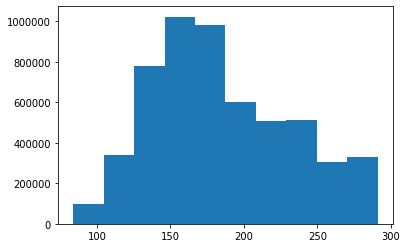

In [28]:
plt.hist(dem[~np.isnan(dem)])

In [4]:
df_features = pd.read_pickle('data/plot_features.pkl')
df_temp = pd.read_pickle('data/PRISM/Tmin/tmin.pkl')

In [5]:
df_static = df_features
df_temp['key'] = 1
df_static['key'] = 1

df_long = df_static.merge(df_temp, on='key').drop('key', axis=1)
df_long = df_long.reset_index(drop=True)

In [6]:
critical_temp = 0  # frost threshold

df_long['slope_norm'] = (df_long['slope_mean'] - df_long['slope_mean'].min()) / \
                        (df_long['slope_mean'].max() - df_long['slope_mean'].min())


df_long['elev_dev_norm'] = (df_long['elev_dev_mean'] - df_long['elev_dev_mean'].min()) / \
                           (df_long['elev_dev_mean'].max() - df_long['elev_dev_mean'].min())


df_long['ndvi_norm'] = (df_long['seasonal_ndvi_mean_of_means'] - df_long['seasonal_ndvi_mean_of_means'].min()) / \
                       (df_long['seasonal_ndvi_mean_of_means'].max() - df_long['seasonal_ndvi_mean_of_means'].min())

df_long['area_norm'] = (df_long['area_m2'] - df_long['area_m2'].min()) / \
                       (df_long['area_m2'].max() - df_long['area_m2'].min())

# Example: larger plots slightly reduce frost risk
# df_long['frost_risk'] += -0.1 * df_long['area_norm']

temp_deficit = (critical_temp - df_long['t_min']).clip(lower=0)
max_deficit = temp_deficit.max()

temp_norm = temp_deficit / max_deficit


df_long['frost_risk'] = (
    (1 - df_long['slope_norm']) * 0.4 +
    (1 - df_long['elev_dev_norm']) * 0.35 +
    (1 - df_long['ndvi_norm']) * 0.15 +
    (1 - df_long['area_norm']) * 0.1
)



# normalize to 0–1 per season or globally
df_long['frost_risk'] = df_long['frost_risk'] / df_long['frost_risk'].max()


In [7]:
df_plot_summary = df_long.groupby('plot_id')['frost_risk'].agg(
    frost_risk_mean='mean',
    frost_risk_std='std',
    frost_risk_max='max'
).reset_index()


In [9]:
df_map = df_features[['plot_id', 'geometry']].merge(df_plot_summary, on='plot_id')


In [10]:
gdf = gpd.GeoDataFrame(df_map, geometry='geometry')


In [11]:
vineyard = gpd.read_file("data/CanoeRidge.geojson")


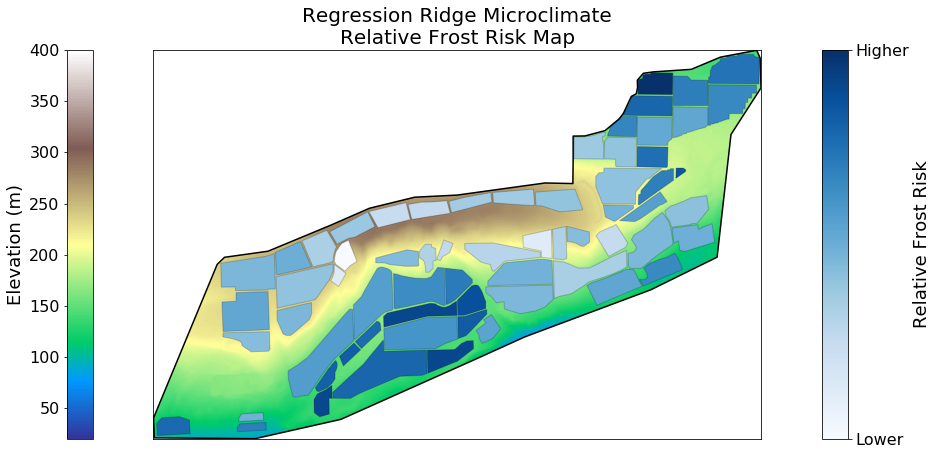

In [29]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import geopandas as gpd

# Ensure GeoDataFrames are in same CRS as DEM
vineyard = vineyard.to_crs(src.crs)
gdf = gdf.to_crs(src.crs)

fig, ax = plt.subplots(figsize=(14, 8))

# 1️⃣ DEM background
im_dem = ax.imshow(
    dem,
    extent=extent,
    origin='upper',
    cmap='terrain',
    vmin = 20,
    vmax = 400
)

# 2️⃣ Overlay frost risk
im_frost = gdf.plot(
    ax=ax,
    column='frost_risk_mean',
    cmap='Blues',
    alpha=1.2,
    edgecolor='black',
    legend=False ,
)

# 3️⃣ Vineyard outline
vineyard.plot(
    ax=ax,
    facecolor='none',
    edgecolor='black',
    linewidth=1.5
)

# 4️⃣ Axes limits and ticks
ax.set_xlim(extent[0], extent[1])
ax.set_ylim(extent[2], extent[3])
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Regression Ridge Microclimate\nRelative Frost Risk Map', fontsize = 20)

# 5️⃣ Create two colorbars
divider = make_axes_locatable(ax)

# Elevation colorbar on the left
cax_left = divider.append_axes("left", size="3%", pad=-1)
cbar_dem = plt.colorbar(im_dem, cax=cax_left)
cbar_dem.set_label('Elevation (m)', fontsize = 18)
cbar_dem.ax.tick_params(labelsize=16)  # set tick label font size

cax_left.yaxis.set_label_position('left')
cax_left.yaxis.set_ticks_position('left')

# Frost risk colorbar on the right
cax_right = divider.append_axes("right", size="3%", pad=-1)
import matplotlib as mpl
norm = mpl.colors.Normalize(vmin=gdf['frost_risk_mean'].min(), vmax=gdf['frost_risk_mean'].max())
sm = plt.cm.ScalarMappable(cmap='Blues', norm=norm)
sm.set_array([])
cbar_frost = plt.colorbar(sm, cax=cax_right, cmap = 'Blues')
cbar_frost.set_ticks([gdf['frost_risk_mean'].min(), gdf['frost_risk_mean'].max()])
cbar_frost.set_ticklabels(['Lower', 'Higher'])
cbar_frost.ax.tick_params(labelsize=16)  # set tick label font size

cbar_frost.set_label('Relative Frost Risk', size = 18)
# Set tick positions and labels
plt.savefig('img/frost_risk.png')

plt.show()
